In [1]:
# Loading libraries

In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time

In [3]:
# Loading directory with data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Creating directory for loaded data

In [6]:
!mkdir -p data

In [7]:
!cd data && tar --extract --file=/content/drive/MyDrive/Colab_Notebooks/cats_dogs_dataset.tar

In [8]:
# Converting to a single image size

In [9]:
image_size = 150

In [10]:
# Creating array for loaded data

In [11]:
def array_creater(dir, target_size = 150):
  imgs = []
  targets = np.array([])
  list_dir = os.listdir(dir)
  for i in list_dir:
    if i[-3:] == 'txt':
      target = np.loadtxt(dir + '/' + i)
      img = cv2.imread(dir + '/' + i[:-3] + 'jpg')
      y_, x_, _ = img.shape
      x_scale = target_size / x_
      y_scale = target_size / y_
      target[1] = float(target[1] * x_scale)
      target[2] = float(target[2] * y_scale)
      target[3] = float(target[3] * x_scale)
      target[4] = float(target[4] * y_scale)
      resized_img = cv2.resize(img, (target_size, target_size))
      targets = np.append(targets, target)
      imgs.append(resized_img)

  targets = targets.reshape(-1,5).astype('float64')
  one_hot = tf.keras.utils.to_categorical(np.where(targets[:,0] == 1, 0, 1))
  targets = np.concatenate((one_hot, targets[:,1:] / target_size), 
                            axis = 1).astype('float64')
  imgs = np.array(imgs).astype('float64') / 255.0
  
  return targets, imgs

In [12]:
imgs_targets = array_creater('/content/data', image_size)

In [13]:
# Let's check arrays size 

In [14]:
print('Images: {} \nTargets: {}'.format(imgs_targets[1].shape, 
                                        imgs_targets[0].shape))

Images: (3385, 150, 150, 3) 
Targets: (3385, 6)


In [15]:
# Let's augment data

In [16]:
def data_augmentation(X, y):
  aug_imgs = []
  aug_targets = np.array([])
  yy = np.copy(y)
  for i in range(y.shape[0]):
    img = cv2.flip(X[i],1)
    target = yy[i]
    x_min = 1 - target[4]
    x_max = 1 - target[2]
    target[2] = x_min
    target[4] = x_max
    aug_targets = np.append(aug_targets, target)
    aug_imgs.append(img)
  return aug_targets.reshape(-1,6), aug_imgs

In [17]:
# Adding augmented data to to main data

In [18]:
aug_data = data_augmentation(imgs_targets[1], imgs_targets[0])
imgs = np.concatenate((imgs_targets[1], aug_data[1]))
targets = np.concatenate((imgs_targets[0], aug_data[0]))

In [19]:
# Splitting data to train, test and validation

In [20]:
X_train, X_test, y_train, y_test = train_test_split(imgs, 
                                                    targets, 
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state=42)

In [21]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, 
                                                    y_test, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [22]:
print('train: {} \ntest: {} \nvalidation: {}'.format(X_train.shape[0], 
                                                      X_test.shape[0], 
                                                      X_valid.shape[0]))

train: 5416 
test: 1083 
validation: 271


In [23]:
# Creating function for visualization images

In [24]:
def show_prediction(img_array, y_true, num, y_pred = None, target_size = 150):
  img = cv2.rectangle(img_array[num], 
                      (int(y_true[num][0]*target_size), 
                       int(y_true[num][1]*target_size)), 
                      (int(y_true[num][2]*target_size), 
                       int(y_true[num][3]*target_size)), 
                      (255, 0, 0), 
                      1)
  img = cv2.putText(img_array[num], 
                    'True', 
                    (int(y_true[num][0]*target_size), 
                     int(y_true[num][1]*target_size) - 1), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.4, 
                    (255,0,0), 
                    1)
  if np.all(y_pred) == None:
    plt.imshow(np.clip(img, 0, 1))
  else:
    img = cv2.rectangle(img_array[num], 
                        (int(y_pred[num][0]*target_size), 
                         int(y_pred[num][1]*target_size)), 
                        (int(y_pred[num][2]*target_size), 
                         int(y_pred[num][3]*target_size)), 
                        (0, 0, 255), 
                        1)
    img = cv2.putText(img_array[num], 
                      'Pred', 
                      (int(y_pred[num][0]*target_size), 
                       int(y_pred[num][1]*target_size) - 1), 
                      cv2.FONT_HERSHEY_SIMPLEX, 
                      0.4, 
                      (0,0,255), 
                      1)
    return np.clip(img, 0, 1)

In [25]:
# Let's look at some examples

In [26]:
# Augmentation:

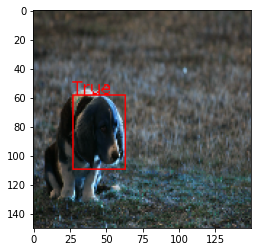

In [27]:
show_prediction(imgs_targets[1], imgs_targets[0][:,2:], 1120)

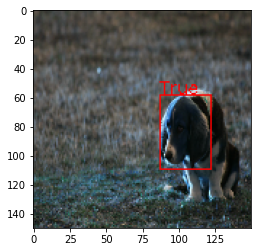

In [28]:
show_prediction(aug_data[1], aug_data[0][:,2:], 1120)

In [29]:
# class MyModel()

In [30]:
# Creating model for class label and bounding box prediction.
# This model has parameters like: base_model - that allow us load 
# pre trained models; reg and clas - allow us debug model

In [31]:
def MyModel(dropout = 0.3, base_model = None, reg = True, clas = True):

  if base_model == None:
    input = tf.keras.layers.Input(shape=X_train.shape[1:])
    x = tf.keras.layers.Conv2D(32, 5, activation='relu', padding='same')(input)
    x = tf.keras.layers.MaxPooling2D(2, padding='same')(x)
    x = tf.keras.layers.Conv2D(64, 5, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(2, padding='same')(x)
    x = tf.keras.layers.Conv2D(128, 5, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(2, padding='same')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(2, padding='same')(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(2, padding='same')(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D(2, padding='same')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Flatten()(x)
  else:
    features_list = [layer.output for layer in base_model.layers]
    model_base = tf.keras.Model(inputs=base_model.input, 
                                           outputs=features_list)
    input = model_base.input
    x = tf.keras.layers.GlobalAveragePooling2D()(model_base.output[-1])

  y_1 = tf.keras.layers.Dense(512, activation='relu')(x)
  y_1 = tf.keras.layers.Dropout(dropout)(y_1)
  y_1 = tf.keras.layers.Dense(256, activation='relu')(y_1)
  y_1 = tf.keras.layers.Dropout(dropout)(y_1)
  y_1 = tf.keras.layers.Dense(128, activation='relu')(y_1)
  y_1 = tf.keras.layers.Dropout(dropout)(y_1)
  y_1 = tf.keras.layers.Dense(128, activation='relu')(y_1)
  y_1 = tf.keras.layers.Dense(64, activation='relu')(y_1)
  out_1 = tf.keras.layers.Dense(4, name="regression")(y_1)

  y_2 = tf.keras.layers.Dense(256, activation='relu')(x)
  y_2 = tf.keras.layers.Dense(128, activation='relu')(y_2)
  y_2 = tf.keras.layers.Dropout(dropout)(y_2)
  y_2 = tf.keras.layers.Dense(64, activation='relu')(y_2)
  out_2 = tf.keras.layers.Dense(2, 
                                activation='softmax', 
                                name="classification")(y_2)

  if reg == True and clas == True:
    model = tf.keras.Model(inputs = input, outputs = [out_1, out_2])
  elif reg == True and clas == False:
    model = tf.keras.Model(inputs = input, outputs = out_1)
  elif reg == False and clas == True:
    model = tf.keras.Model(inputs = input, outputs = out_2)
  else:
    print('No output!')

  return model

In [32]:
# Let's first create the model ourself and see how accurately it predicts.

In [33]:
model = MyModel()

In [34]:
# Let's look at the structure 

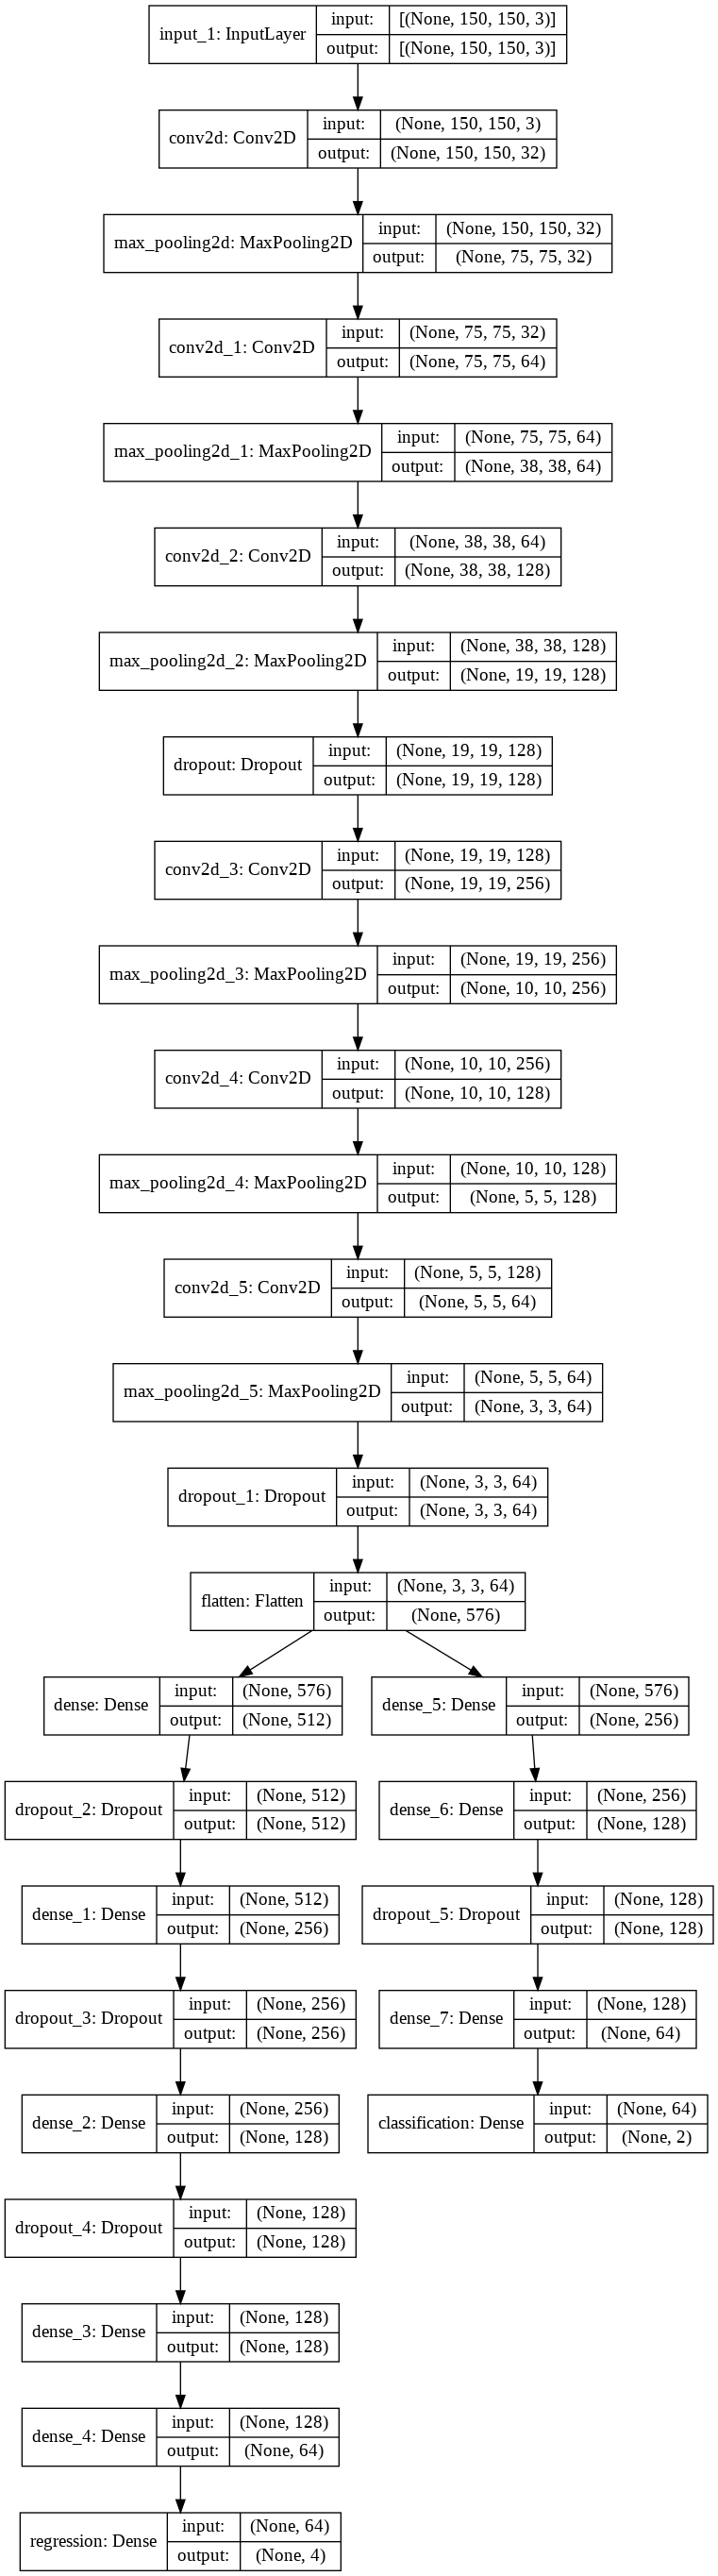

In [35]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [48]:
# model.summary()

In [36]:
# Compiling and fitting the model

In [39]:
model.compile(
    optimizer = 'Adam',
    loss = {'regression': 'mse', 'classification': 'categorical_crossentropy'},
    loss_weights = [5, 1],
    metrics = {'regression': 'mae', 'classification': 'accuracy'})

In [40]:
model.fit(X_train, 
          [y_train[:,2:], y_train[:,:2]],  
          epochs=80, 
          validation_data = (X_test, [y_test[:,2:], y_test[:,:2]]), 
          batch_size=64)

Epoch 1/80
85/85 [==============================] - 8s 60ms/step - loss: 1.0503 - regression_loss: 0.0839 - classification_loss: 0.6308 - regression_mae: 0.2161 - classification_accuracy: 0.6678 - val_loss: 0.7511 - val_regression_loss: 0.0276 - val_classification_loss: 0.6132 - val_regression_mae: 0.1300 - val_classification_accuracy: 0.7054
Epoch 2/80
85/85 [==============================] - 4s 42ms/step - loss: 0.7470 - regression_loss: 0.0246 - classification_loss: 0.6240 - regression_mae: 0.1242 - classification_accuracy: 0.6849 - val_loss: 0.7474 - val_regression_loss: 0.0280 - val_classification_loss: 0.6075 - val_regression_mae: 0.1308 - val_classification_accuracy: 0.7054
Epoch 3/80
85/85 [==============================] - 4s 42ms/step - loss: 0.7266 - regression_loss: 0.0232 - classification_loss: 0.6107 - regression_mae: 0.1212 - classification_accuracy: 0.6927 - val_loss: 0.7029 - val_regression_loss: 0.0236 - val_classification_loss: 0.5847 - val_regression_mae: 0.1209 - v

In [41]:
# Process of fitting

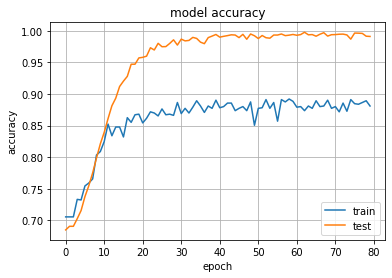

In [42]:
plt.plot(model.history.history['val_classification_accuracy'])
plt.plot(model.history.history['classification_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.grid()
plt.show()

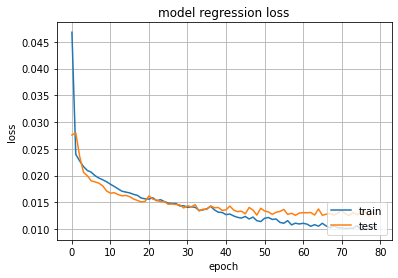

In [43]:
plt.plot(model.history.history['regression_loss'])
plt.plot(model.history.history['val_regression_loss'])
plt.title('model regression loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.grid()
plt.show()

In [45]:
# Creating function for evaluate Mean Intersection-Over-Union

In [46]:
def mIoU(y_true, y_pred, plus = 0):
  miou = []
  for i in range(y_pred.shape[0]):
    xA = max(y_true[i][0], y_pred[i][0])
    yA = max(y_true[i][1], y_pred[i][1])
    xB = min(y_true[i][2], y_pred[i][2])
    yB = min(y_true[i][3], y_pred[i][3])
    in_area = max(0, xB - xA + plus) * max(0, yB - yA + plus)
    out_area1 = max(0, y_true[i][2] 
                    - y_true[i][0] + plus) * max(0, y_true[i][3] - y_true[i][1] + plus)
    out_area2 = max(0, y_pred[i][2]
                    - y_pred[i][0] + plus) * max(0, y_pred[i][3] - y_pred[i][1] + plus)
    iou = in_area / float(out_area1 + out_area2 - in_area)
    miou.append(iou)
  mIoU = sum(miou) / len(miou)
  return mIoU

In [47]:
# Creating function for inference 

In [48]:
def inference(model, x_valid = X_valid, y_valid = y_valid, clas = True):
  start_time = time.time()
  y_pred = model.predict(x_valid)
  if clas == True:
    y_pred = model.predict(x_valid)
    print(classification_report(np.argmax(y_valid[:,:2], axis = 1),
                                np.argmax(y_pred[1], axis = 1)))
  else:
    y_pred = np.array(model.predict(x_valid))[None, ...]
  print('--'*27)
  print('mIoU: {}'.format(mIoU(y_valid[:,2:], y_pred[0])))
  print('--'*27)
  print('train: {} \ntest: {} \nvalidation: {}'.format(X_train.shape[0], 
                                                      X_test.shape[0], 
                                                      x_valid.shape[0]))
  print('--'*27)
  print("sec: {}".format(round((time.time() - start_time), 3)))
  print('--'*27)
  print('Some examples:')
  fig, axs = plt.subplots(1,5, sharex=True, sharey=True, figsize=(20,20))
  for i, j in enumerate(np.random.randint(0, x_valid.shape[0], 5)):
    axs[i].imshow(show_prediction(x_valid, y_valid[:,2:], j, y_pred[0]))
    if clas == True:
      axs[i].set_title('True label: {} \nPredicted label: {}'.format(
          np.where(np.argmax(y_valid[:,:2][j]) == 1, 'dog', 'cat'),
          np.where(np.argmax(y_pred[1][j]) == 1, 'dog', 'cat')))
    else:
      pass

In [49]:
# Let's look at the our model prediction and metrics 

              precision    recall  f1-score   support

           0       0.78      0.80      0.79        79
           1       0.92      0.91      0.91       192

    accuracy                           0.87       271
   macro avg       0.85      0.85      0.85       271
weighted avg       0.88      0.87      0.87       271

------------------------------------------------------
mIoU: 0.47099675043887673
------------------------------------------------------
train: 5416 
test: 1083 
validation: 271
------------------------------------------------------
sec: 0.716
------------------------------------------------------
Some examples:


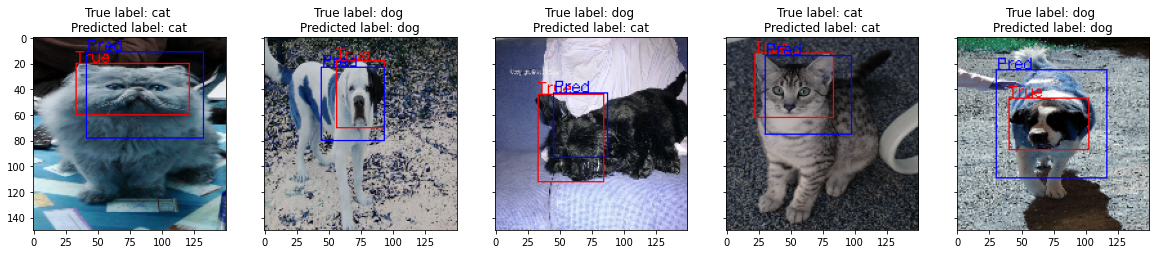

In [50]:
inference(model)

In [51]:
# As we can see, our model defines the bounding box rather poorly.
# To solve this problem we can load pre trained model.
# We will take as a basis Xception model. 
# Let's drop head of the model.

In [52]:
base_model = tf.keras.applications.Xception(weights='imagenet', 
                                            include_top = False, 
                                            input_shape = (image_size, 
                                                           image_size, 
                                                           3))

In [53]:
# Let's make our model trainable

In [54]:
base_model.trainable = True

In [55]:
model_2 = MyModel(base_model = base_model)

In [56]:
model_2.compile(
    optimizer = 'Adam',
    loss = {'regression': 'mse', 'classification': 'categorical_crossentropy'},
    loss_weights = [5, 1],
    metrics = {'regression': 'mae', 'classification': 'accuracy'})

In [57]:
model_2.fit(X_train, 
          [y_train[:,2:], y_train[:,:2]],  
          epochs=50, 
          validation_data = (X_test, [y_test[:,2:], y_test[:,:2]]), 
          batch_size=64)

Epoch 1/50
85/85 [==============================] - 37s 374ms/step - loss: 0.6642 - regression_loss: 0.0665 - classification_loss: 0.3316 - regression_mae: 0.1910 - classification_accuracy: 0.8519 - val_loss: 0.2834 - val_regression_loss: 0.0201 - val_classification_loss: 0.1830 - val_regression_mae: 0.1095 - val_classification_accuracy: 0.9723
Epoch 2/50
85/85 [==============================] - 30s 351ms/step - loss: 0.1741 - regression_loss: 0.0200 - classification_loss: 0.0743 - regression_mae: 0.1105 - classification_accuracy: 0.9768 - val_loss: 0.2339 - val_regression_loss: 0.0178 - val_classification_loss: 0.1449 - val_regression_mae: 0.1046 - val_classification_accuracy: 0.9705
Epoch 3/50
85/85 [==============================] - 30s 351ms/step - loss: 0.1054 - regression_loss: 0.0138 - classification_loss: 0.0365 - regression_mae: 0.0920 - classification_accuracy: 0.9872 - val_loss: 1.7115 - val_regression_loss: 0.0199 - val_classification_loss: 1.6123 - val_regression_mae: 0.10

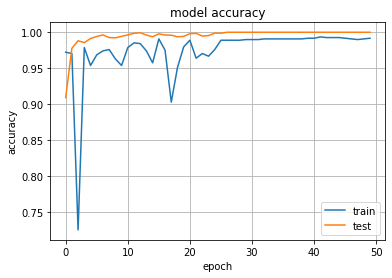

In [58]:
plt.plot(model_2.history.history['val_classification_accuracy'])
plt.plot(model_2.history.history['classification_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.grid()
plt.show()

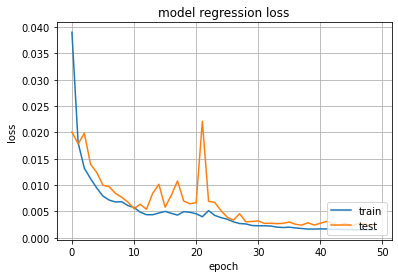

In [59]:
plt.plot(model_2.history.history['regression_loss'])
plt.plot(model_2.history.history['val_regression_loss'])
plt.title('model regression loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.grid()
plt.show()

In [ ]:
# Let's look at the pre trained model prediction and metrics 

              precision    recall  f1-score   support

           0       0.82      0.95      0.88        79
           1       0.98      0.92      0.95       192

    accuracy                           0.93       271
   macro avg       0.90      0.93      0.91       271
weighted avg       0.93      0.93      0.93       271

------------------------------------------------------
mIoU: 0.6727453370034918
------------------------------------------------------
train: 5416 
test: 1083 
validation: 271
------------------------------------------------------
sec: 0.765
------------------------------------------------------
Some examples:


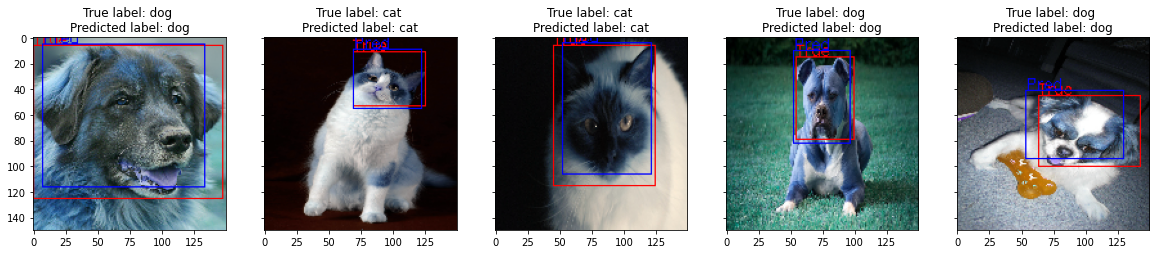

In [62]:
inference(model_2)

In [ ]:
# As we can see, pre trained model defines the bounding box better.
# Also pre trained model more accurately determines the class of the animal.

In [ ]:
# What else could we do to improve the model?
# 1 - Load newer, more accurate model like EfficientNet
# 2 - Augment data more diversified
# 3 - Consider a more optimal model head
# 4 - Increase the size of the input image
# 5 - Сhange the data structure: make a bounding box with coordinates like
# [-1, -1, -1, -1] for the wrong class and for the True class, keep the same
# 6 - Find more optimal hyperparameters